- - -
**File name**: evaluation_wrf.ipynb

**Author**:  Ueslei Adriano Sutil

**Email**: [ueslei@putlook.com](mailto:ueslei@putlook.com)

**Created**: 30 September 2020

**Last modified**: 30 September 2020

**Version**: 1.0

**Python**: 3.7.9
- - -
<br>


** 1. Evaluate WRF output using:**

- Bias (Contour);
<br>
$
\begin{equation}
BIAS = A_{t}-F_{t}
\end{equation}
$

- Root Mean Square Error (RMSE; Contour);
<br>
$
\begin{equation}
RMSE = \sqrt{\sum_{i=1}^{n}\frac{(A_{t}-F_{t})^2}{n}}
\end{equation}
$

- Mean Absolute Percentage Error (MAPE; Contour);
<br>
$
\begin{equation}
MAPE = \frac{1}{n}\sum_{t=1}^{n}\left | \frac{A_{t}-F_{t}}{A_{t}} \right |
\end{equation}
$
<br>

Where $A_{t}$ is the actual value, $F_{t}$ is the forecast value and $n$ is the number of observations.
<br>

** 2. Compare WRF output with:**
- ERA5 (Hersbach et al., 2018; [[Access here]](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview)):
    - Temperature at 2 meters height (°C);
    - Wind Speed at 10 m height (m/s);
    - Sea Level Pressure (hPa);

- CFSR (Saha et al., 2010; [[Acess here]](https://rda.ucar.edu/datasets/ds093.0/)):
    - Temperature at 2 meters height (°C);
    - Wind Speed at 10 m height (m/s);
    - Sea Level Pressure (hPa);


** 3. Disclaimers: **
- Both Observed and Simulated variables needs to match the same time-step. 
- Post-process commands to do with WRF outputs to match with the databases: 

    `cdo seltimestep,169/336 wrf.nc wrf_ts.nc`

    `cdo timselmean,6 wrf_ts.nc wrf_6h_ncks.nc`

    `cdo daymean wrf_6h_ncks.nc wrf_daymean_ncks.nc`


#### 1. Import libraries.


In [1]:
import netCDF4
import pyresample
import cmocean
import os
from   mpl_toolkits.basemap import Basemap
from   wrf                  import getvar,extract_times
from   roms_libs            import *
from   tqdm                 import tqdm
from   time                 import sleep
import numpy                as np
import matplotlib.pyplot    as plt


#### 2. Set customizations.

In [2]:
# Set map boundaries.
bbox            = [-53,-43,-31,-23]
lonbounds       = [-53,-43] 
latbounds       = [-31,-23]

# Set files path.
wrf_file        = '/media/ueslei/Ueslei_HD/INPE/PCI/Projetos/SC_2008/Outputs/normal/wrf.nc'
wrf_file_cfsr   = '/media/ueslei/Ueslei_HD/INPE/PCI/Projetos/SC_2008/Outputs/normal/wrf.nc'

# Set range.
clevs_rmse = np.arange(0,5.05,0.01)
ticks_rmse = np.arange(min(clevs_rmse),max(clevs_rmse),1)
clevs_mape = np.arange(0,1.02,0.01)
ticks_mape = np.arange(min(clevs_mape),max(clevs_mape),0.1)
clevs_bias = np.arange(-4,4.1,0.01)
ticks_bias = np.arange(min(clevs_bias),max(clevs_bias),1)

#### 3. Choose which datase, variable and metric will be used to compare with WRF output.

In [3]:
print('Which data? (1) ERA5 or (2) CFSR?')      
dataset  = input()
print('Evaluate which WRF-ARW variable? (1) Temperature at 2 meters, (2) Wind Speed at 10m, (3) Sea Level Pressure?')
contourf_var = input()
print('Which statistical metric? (1) Root Mean Square Error, (2) Mean Absolute Error or (3) Bias.')
metric  = input()

Which data? (1) ERA5 or (2) CFSR?
Evaluate which WRF-ARW variable? (1) Temperature at 2 meters, (2) Wind Speed at 10m, (3) Sea Level Pressure?
Which statistical metric? (1) Root Mean Square Error, (2) Mean Absolute Error or (3) Bias.


#### 4. Collect data from the observed data.

In [4]:
# Open files and load lat/lon coords.
if dataset == '1':
    era_file = '/media/ueslei/Ueslei_HD/INPE/PCI/Projetos/SC_2008/Dados/Evaluation/ERA5/era5_novo.nc'
    nc_obs    = netCDF4.Dataset(era_file)
    lon_obs   = nc_obs.variables['longitude'][:]-360
    lat_obs   = nc_obs.variables['latitude'][:]
else:
    cfsr_file = '/media/ueslei/Ueslei_HD/INPE/PCI/Projetos/SC_2008/Dados/Evaluation/CFSR/cfsr.nc'
    nc_obs    = netCDF4.Dataset(era_file)
    lon_obs   = nc_obs.variables['lon'][:]
    lat_obs   = nc_obs.variables['lat'][:]

# Calculate lat/lon coords based on the bounds chosen in step 2.
latli = np.argmin(np.abs(lat_obs-latbounds[1]))
latui = np.argmin(np.abs(lat_obs-latbounds[0])) 
lonli = np.argmin(np.abs(lon_obs-lonbounds[0]))
lonui = np.argmin(np.abs(lon_obs-lonbounds[1])) 

# Reopen lat/lon coords with the exactly gridpoin based on the chosen bounds.
if dataset == '1':
    lon_obs = nc_obs.variables['longitude'][lonli:lonui]-360
    lat_obs = nc_obs.variables['latitude'][latli:latui]
else:
    lon_obs = nc_obs.variables['lon'][lonli:lonui]
    lat_obs = nc_obs.variables['lat'][latli:latui]

# Mesh grid.
lon_obs,lat_obs = np.meshgrid(lon_obs,lat_obs)
lat_obs_len = len(lat_obs[:,0])
lon_obs_len = len(lon_obs[0, :])

# Count how many time steps in file.
loop = len(nc_obs.variables['time'][:])

# Create variable to store data.
if contourf_var == '1' or '3':
    var = np.zeros([loop,lat_obs_len,lon_obs_len])
    observed = np.zeros([loop,lat_obs_len,lon_obs_len])
if contourf_var == '2':
    var1 = np.zeros([loop,lat_obs_len,lon_obs_len])
    var2 = np.zeros([loop,lat_obs_len,lon_obs_len])
    observed1 = np.zeros([loop,lat_obs_len,lon_obs_len])
    observed2 = np.zeros([loop,lat_obs_len,lon_obs_len])

# Do the loop though the time steps and store data in a new observed variable.
with tqdm(total=loop) as pbar:
    for i in range(0,loop):
        if dataset=='1' and contourf_var=='1':
            var = nc_obs.variables['t2m'][i,latli:latui,lonli:lonui]-273.15
            observed[i,:,:] = var
        elif dataset=='1' and contourf_var=='2':
            var1 = nc_obs.variables['u10'][i,latli:latui,lonli:lonui]
            var2 = nc_obs.variables['v10'][i,latli:latui,lonli:lonui]
            observed1[:,:] = var1
            observed2[:,:] = var2 
        elif dataset=='1' and contourf_var=='3':
            var = nc_obs.variables['msl'][i,latli:latui,lonli:lonui]/100
            observed[i,:,:] = var
        elif dataset=='2' and contourf_var=='1':
            var = nc_obs.variables['TMP_L103'][i,latli:latui,lonli:lonui]-273.15
            observed[i,:,:] = var
        elif dataset=='2' and contourf_var=='2':
            var1 = nc_obs.variables['U_GRD_L103'][i,latli:latui,lonli:lonui]
            var2 = nc_obs.variables['V_GRD_L103'][i,latli:latui,lonli:lonui]
            observed1[i,:,:] = var1
            observed2[i,:,:] = var2 
        elif dataset=='2' and contourf_var=='3':
            var = nc_obs.variables['PRES_L101'][i,latli:latui,lonli:lonui]/100              
            observed[i,:,:] = var
        sleep(0.1)
        pbar.update(1)
if contourf_var =='2':
    observed = np.sqrt(observed1**2 + observed2**2)

100%|██████████| 168/168 [00:19&lt;00:00,  8.62it/s]


#### 4. Collect data from the resampled simulated data.

In [5]:
# Open files and load lat/lon coords.
nc_sim      = netCDF4.Dataset(wrf_file)
lon_sim     = nc_sim.variables['XLONG'][0,0,:]
lat_sim     = nc_sim.variables['XLAT'][0,:,0]   

# Calculate lat/lon coords based on the bounds chosen in step 2.
latli       = np.argmin(np.abs(lat_sim-latbounds[1]))
latui       = np.argmin(np.abs(lat_sim-latbounds[0])) 
lonli       = np.argmin(np.abs(lon_sim-lonbounds[0]))
lonui       = np.argmin(np.abs(lon_sim-lonbounds[1]))
lon_sim     = lon_sim[lonli:lonui]
lat_sim     = lat_sim[latui:latli]
lon_sim,lat_sim = np.meshgrid(lon_sim,lat_sim)         

# It is suggested to start evaluating the simulated data days/months after the run is started. Choose the date:
dt = extract_times(nc_sim,timeidx=None)
dt = np.datetime_as_string(dt)
sim_start = 95 
sim_stop  = 263
sim_len   = sim_stop-sim_start

# Calculate grid length.
lat_sim_len = len(lat_sim[:,0])
lon_sim_len = len(lon_sim[0,:])

# First step to resample simulate data.
orig = pyresample.geometry.SwathDefinition(lons=lon_sim, lats=lat_sim)
targ = pyresample.geometry.SwathDefinition(lons=lon_obs, lats=lat_obs)

# Create the expected and var variables.
if contourf_var == '1' or '3':
    var = np.zeros([loop,lat_sim_len,lon_sim_len])
    expected = np.zeros([loop,lat_obs_len,lon_obs_len])
if contourf_var == '2':
    var1 = np.zeros([loop,lat_sim_len,lon_sim_len])
    var2 = np.zeros([loop,lat_sim_len,lon_sim_len])
    expected1 = np.zeros([loop,lat_obs_len,lon_obs_len])
    expected2 = np.zeros([loop,lat_obs_len,lon_obs_len])


# First loop to store cropped variable with right time steps.
with tqdm(total=sim_len) as pbar:
    for range_sim in range(sim_start,sim_stop): 
        if dataset=='1' and contourf_var=='1':
            var[:,:,:] = nc_sim.variables['T2'][range_sim,latui:latli,lonli:lonui]-273.15
        elif dataset=='1' and contourf_var=='2':
            var1[:,:,:] = nc_sim.variables['U10'][range_sim,latui:latli,lonli:lonui]
            var2[:,:,:] = nc_sim.variables['V10'][range_sim,latui:latli,lonli:lonui]
        elif dataset=='1' and contourf_var=='3':
            var[:,:,:] = getvar(nc_sim, "slp", range_sim, units="hPa",meta=False)[latui:latli,lonli:lonui]
        sleep(0.1)
        pbar.update(1)

# Second loop to resample with the stored variable.
with tqdm(total=loop) as pbar:
    for i in range(0,loop,1): 
        if dataset=='1' and contourf_var=='1':      
            expected[i,:,:] = pyresample.kd_tree.resample_gauss(orig, var[i,:,:], targ,radius_of_influence=50000, sigmas=25000, fill_value=None)
        elif dataset=='1' and contourf_var=='2':
            expected1[i,:,:] = pyresample.kd_tree.resample_gauss(orig, var1[i,:,:], targ, radius_of_influence=50000, neighbours=10,sigmas=25000, fill_value=None)
            expected2[i,:,:] = pyresample.kd_tree.resample_gauss(orig, var2[i,:,:], targ, radius_of_influence=50000, neighbours=10,sigmas=25000, fill_value=None)
        elif dataset=='1' and contourf_var=='3':
            expected[i,:,:] = pyresample.kd_tree.resample_gauss(orig, var[i,:,:], targ, radius_of_influence=50000, neighbours=10,sigmas=25000, fill_value=None)
        sleep(0.1)
        pbar.update(1)
if contourf_var =='2':
    expected = np.sqrt(expected1**2 + expected2**2)

SystemError: 0

** 5. Calculate the metrics. **

In [ ]:
# Calculate Root Mean Square Error.
if metric=='1':
    differences         = expected-observed
    differences_squared = differences ** 2 
    mean_of_differences_squared = np.average(differences_squared,axis=0)
    val                 = np.sqrt(mean_of_differences_squared)

# Calculate Mean Absolute Error.
elif metric=='2':
    val = np.abs((observed-expected)/observed).mean(axis=0)*100

# Calculate Bias.
elif metric=='3':
    expected1 = np.average(expected,axis=0) 
    observed1 = np.average(observed,axis=0)
    val       = expected1-observed1


** 6. Create and plot map and then save. **

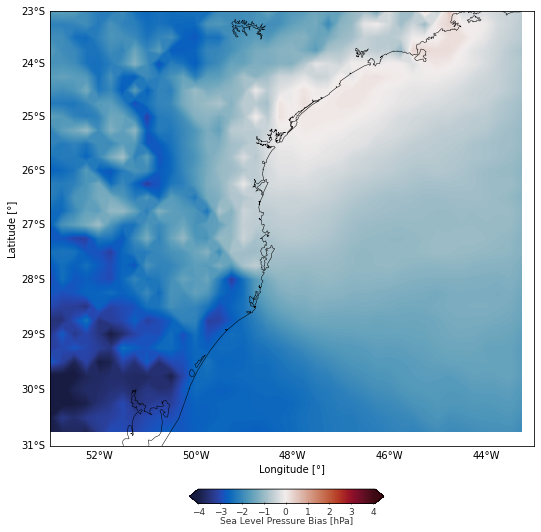

In [18]:
# Map options.
m    = Basemap(projection='merc',llcrnrlat=bbox[2],urcrnrlat=bbox[3],llcrnrlon=bbox[0],urcrnrlon=bbox[1], lat_ts=30,resolution='i')
fig  = plt.figure(1,figsize=(10,8))
plt.xlabel('Longitude'u' [\N{DEGREE SIGN}]',labelpad=18,size=10)
plt.ylabel('Latitude'u' [\N{DEGREE SIGN}]',labelpad=33,size=10)
ax   = fig.add_subplot(111)
m.drawparallels(np.arange(-90.,120.,1), linewidth=0.00, color='black', labels=[1,0,0,1],labelstyle="N/S",fontsize=10)
m.drawmeridians(np.arange(-180.,180.,2), linewidth=0.00,color='black', labels=[1,0,0,1],labelstyle="N/S",fontsize=10)
m.drawcountries(color = '#000000',linewidth=0.5)
m.drawcoastlines(color = '#000000',linewidth=0.5)

# Map ticks and gradient.
if metric=='1':
    clevs = clevs_rmse
    ticks = ticks_rmse
elif metric=='2':
    clevs = clevs_mape
    ticks = ticks_mape
elif metric=='3':
    clevs = clevs_bias
    ticks = ticks_bias

# Map pallete and plot.
if metric=='1' or metric=='2':
    cmap  = cmocean.cm.thermal
    h1    = m.contourf(lon_obs, lat_obs, val, clevs,latlon=True,cmap=cmap,extend="both")
elif metric=='3':
    cmap  = cmocean.cm.balance
    h1    = m.contourf(lon_obs, lat_obs, val, clevs,latlon=True,cmap=cmap,norm=MidpointNormalize(midpoint=0),extend="both")          
cax   = fig.add_axes([0.37, 0.025, 0.27, 0.025])     
cb    = fig.colorbar(h1, cax=cax, orientation="horizontal",panchor=(0.5,0.5),shrink=0.3,ticks=ticks,pad=-10.5)

# Map legend.
if metric=='1':
    if contourf_var=='1':
        cb.set_label(r'Air Temperature at 2 meters Root Mean Square Error [$^\circ\!$C]', fontsize=9, color='0.2',labelpad=0)
    elif contourf_var=='2':
        cb.set_label(r'Wind Speed at 10 meters Root Mean Square Error [m.s⁻¹]', fontsize=9, color='0.2',labelpad=0)
    elif contourf_var=='3':
         cb.set_label(r'Sea Level Pressure Root Mean Square Error [hPa]', fontsize=9, color='0.2',labelpad=0)       
elif metric=='2':
    if contourf_var=='1':
        cb.set_label(r'Air Temperature at 2 meters Mean Absolute Percentage Error [%]', fontsize=9, color='0.2',labelpad=-0.2)
    elif contourf_var=='2':
        cb.set_label(r'Wind Speed at 10 meters Mean Absolute Percentage Error [%]', fontsize=9, color='0.2',labelpad=-0.2)
    elif contourf_var=='3':
        cb.set_label(r'Sea Level Pressure Mean Absolute Percentage Error [%]', fontsize=9, color='0.2',labelpad=-0.2)     
elif metric=='3':
    if contourf_var=='1':
        cb.set_label(r'Air Temperature at 2 meters Bias [$^\circ\!$C]', fontsize=9, color='0.2',labelpad=-0.2)
    elif contourf_var=='2':
        cb.set_label(r'Wind Speed at 10 meters Bias [m.s⁻¹]', fontsize=9, color='0.2',labelpad=-0.2)
    elif contourf_var=='3':
        cb.set_label(r'Sea Level Pressure Bias [hPa]', fontsize=9, color='0.2',labelpad=-0.2)  
            
cb.ax.tick_params(labelsize=9, length=2, color='0.2', labelcolor='0.2',direction='in') 
cb.set_ticks(ticks)

# Create folder to store the figures.
try:
    os.makedirs("wrf_evaluation")
except FileExistsError:
    pass 

# Save figure according to their respective name.
if metric == '1' and dataset == '1' and contourf_var == '1':
        plt.savefig('./wrf_evaluation/t2_rmse_wrf_era5.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)              
elif metric == '1' and dataset == '1' and contourf_var == '2':
        plt.savefig('./wrf_evaluation/wind_rmse_wrf_era5.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)              
elif metric == '1' and dataset == '1' and contourf_var == '3':
        plt.savefig('./wrf_evaluation/slp_rmse_wrf_era5.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)
elif metric == '2' and dataset == '1' and contourf_var == '1':
        plt.savefig('./wrf_evaluation/t2_mape_wrf_era5.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)              
elif metric == '2' and dataset == '1' and contourf_var == '2':
        plt.savefig('./wrf_evaluation/wind_mape_wrf_era5.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)              
elif metric == '2' and dataset == '1' and contourf_var == '3':
        plt.savefig('./wrf_evaluation/slp_mape_wrf_era5.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)   
elif metric == '3' and dataset == '1' and contourf_var == '1':
        plt.savefig('./wrf_evaluation/t2_bias_wrf_era5.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)              
elif metric == '3' and dataset == '1' and contourf_var == '2':
        plt.savefig('./wrf_evaluation/wind_bias_wrf_era5.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)              
elif metric == '3' and dataset == '1' and contourf_var == '3':
        plt.savefig('./wrf_evaluation/slp_bias_wrf_era5.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)
elif metric == '1' and dataset == '2' and contourf_var == '1':
        plt.savefig('./wrf_evaluation/t2_rmse_wrf_cfsr.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)              
elif metric == '1' and dataset == '2' and contourf_var == '2':
        plt.savefig('./wrf_evaluation/wind_rmse_wrf_cfsr.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)              
elif metric == '1' and dataset == '2' and contourf_var == '3':
        plt.savefig('./wrf_evaluation/slp_rmse_wrf_cfsr.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)
elif metric == '2' and dataset == '2' and contourf_var == '1':
        plt.savefig('./wrf_evaluation/t2_mape_wrf_cfsr.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)              
elif metric == '2' and dataset == '2' and contourf_var == '2':
        plt.savefig('./wrf_evaluation/wind_mape_wrf_cfsr.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)              
elif metric == '2' and dataset == '2' and contourf_var == '3':
        plt.savefig('./wrf_evaluation/slp_mape_wrf_cfsr.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)
elif metric == '3' and dataset == '2' and contourf_var == '1':
        plt.savefig('./wrf_evaluation/t2_bias_wrf_cfsr.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)              
elif metric == '3' and dataset == '2' and contourf_var == '2':
        plt.savefig('./wrf_evaluation/wind_bias_wrf_cfsr.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250)              
elif metric == '3' and dataset == '2' and contourf_var == '3':
        plt.savefig('./wrf_evaluation/slp_bias_wrf_cfsr.png', transparent=False, bbox_inches = 'tight', pad_inches=0, dpi=250) 